<h2>Packages and Reading Data</h2>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import scale,normalize, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, log_loss, roc_auc_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
warnings.filterwarnings("ignore", category=FutureWarning)
pd.set_option("max_rows",1000)
pd.set_option("max_columns",100)

<h2>About Data</h2>

The data Contains the customer details and whether his income is above 50k or not

Age  : Age of customer (Min is 17)

Work Class: In which sector customer is working

Education Level  : Educational qualification of the customer

Education-num-Years : Total Years into Education

Marital-status : Maritual Status of the customer

Occupation : Occupation of the customer

Relationship : Relationship of the customer

Race : Black/White or other

Sex : Male/Female or other

Avg Hours-per-week worked : On average how many weeks customer works

Income : >50k or <50k

In [49]:
census_data_df = pd.read_excel(os.getcwd()+"\Census_Data_Reduced_v2.xlsx")

In [50]:
census_data_df.head()

,Age,Workclass,Education Level,Education-num-Years,Marital-status,Occupation,Relationship,Race,Sex,Avg Hours-per-week worked,Income
0,30,Private,Some-college,10,Separated,Sales,Unmarried,Black,Female,16,<=50K
1,34,Private,HS-grad,9,Never-married,Exec-managerial,Other-relative,White,Male,50,<=50K
2,34,Private,HS-grad,9,Divorced,Machine-op-inspct,Unmarried,Black,Female,40,<=50K
3,30,Private,Assoc-acdm,12,Divorced,Sales,Not-in-family,White,Male,52,<=50K
4,51,Self-emp-not-inc,Some-college,10,Divorced,Craft-repair,Not-in-family,White,Male,8,>50K


In [51]:
census_data_df.columns=['age', 'workclass', 'education_level', 'education_num_years',
       'marital_status', 'occupation', 'relationship', 'race', 'sex',
       'avg_hours_per_week_worked', 'income']

<h2>Data Imputation and Cleaning</h2>

In [52]:
# Convert the income to class variable
census_data_df['income_class'] =census_data_df['income'].map(lambda df: 1 if (df==' >50K') else 0).astype(int)

In [54]:
census_data_df.head()

,age,workclass,education_level,education_num_years,marital_status,occupation,relationship,race,sex,avg_hours_per_week_worked,income,income_class
0,30,Private,Some-college,10,Separated,Sales,Unmarried,Black,Female,16,<=50K,0
1,34,Private,HS-grad,9,Never-married,Exec-managerial,Other-relative,White,Male,50,<=50K,0
2,34,Private,HS-grad,9,Divorced,Machine-op-inspct,Unmarried,Black,Female,40,<=50K,0
3,30,Private,Assoc-acdm,12,Divorced,Sales,Not-in-family,White,Male,52,<=50K,0
4,51,Self-emp-not-inc,Some-college,10,Divorced,Craft-repair,Not-in-family,White,Male,8,>50K,1


In [53]:
# We can see some junk data in workclass and cccupation, so lets clean it before moving ahead
census_data_df = census_data_df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
census_data_df.loc[lambda df: df.workclass=='?',['workclass','occupation']]='NA'
census_data_df = census_data_df.apply(lambda x: x.str.lower().replace('-','_') if x.dtype == "object" else x)

In [67]:
census_data_df.groupby(['education_level','education_num_years'])['education_num_years'].count()

education_level  education_num_years
10th             6                       249
11th             7                       331
12th             8                       136
1st_4th          2                        42
5th_6th          3                        84
7th_8th          4                       166
9th              5                       138
assoc_acdm       12                      285
assoc_voc        11                      382
bachelors        13                     1483
doctorate        16                      116
hs_grad          9                      2902
masters          14                      471
preschool        1                         6
prof_school      15                      178
some_college     10                     2030
Name: education_num_years, dtype: int64

<b>Analysis</b>

The Numerical value of the education_level is education_num_years, since no need to use the education_level column or neither encoding is not required for this,hence removing this column

<h2>Data Description</h2>

In [69]:
census_data_df.describe()

,age,education_num_years,avg_hours_per_week_worked,income_class
count,8999.000000,8999.000000,8999.000000,8999.000000
mean,38.564729,10.116013,40.325258,0.245027
std,13.654332,2.539637,12.253032,0.430127
min,17.000000,1.000000,1.000000,0.000000
25%,28.000000,9.000000,40.000000,0.000000
50%,37.000000,10.000000,40.000000,0.000000
75%,47.000000,12.000000,45.000000,0.000000
max,90.000000,16.000000,99.000000,1.000000


<b>Analysis</b>

The average age is 38 and education is 10th

The average hours worked per week is 40 hours

<h2>Data Balanncing check</h2>

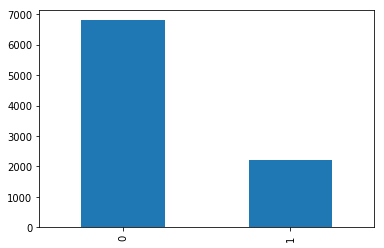

In [71]:
census_data_df['income_class'].value_counts().plot(kind='bar')

<b>Analysis</b>

The Customers with >50k income are ~2300 whereas customers with <=50k are 6500, we can see the clear data imbalance, this could bias our results

<h2>Data Modelling</h2>

In [86]:
#Some useful functions
def plot_confusion_matrix(test_y, predict_y):
        test_y = test_y.astype(int)
        predict_y = predict_y.astype(int)
        C = confusion_matrix(test_y, predict_y)
        C = C.astype(int)
        labels = ['0','1']
        print("-"*20, "Confusion matrix", "-"*20)
        plt.figure(figsize=(15,7))
        sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".0f", xticklabels=labels, yticklabels=labels)
        plt.xlabel('Predicted Class')
        plt.ylabel('Original Class')
        plt.show()

#Hyperparameter tuning the model (Non tree models)
def tuning(model, parameters, parameter_name, train_data_x, train_data_y, plot_values,is_multi=False):
    grid = GridSearchCV(model, parameters, cv = 3, scoring = 'f1_macro',return_train_score=True)
    grid.fit(train_data_x, train_data_y)
    results = pd.DataFrame(grid.cv_results_)           #storing results of gridseachcv in a dataframe to access its elements
    params = results['params']                         #storing combination of parameters used by model in params
    score_tr_array = results['mean_train_score']         #storing scores on train data of model
    score_cv_array = results['mean_test_score']          #storing scores on cv data of model
    for i in range(len(params)):
        print("For", params[i]," acc of Train data is", score_tr_array[i],"and acc of CV data is", score_cv_array[i])
    print('Best Parameter is ',  grid.best_params_)
    print('Best F1 Score is ',  grid.best_score_)
    if not is_multi:
        plt.xlabel(parameter_name)
        plt.title('Cross Validation')
        plt.plot(plot_values,grid.cv_results_['mean_train_score'])
        plt.plot(plot_values,grid.cv_results_['mean_test_score'])
        plt.legend(['Train Accuracy', 'CV Accuracy'])
        plt.show()
    return grid.best_params_

def tuning_random(model, parameters, parameter_name, train_data_x, train_data_y, plot_values,is_multi=False,extra_params={},model_tags=[]):
        grid = RandomizedSearchCV(model, parameters, cv = 3,n_jobs=-1,scoring = 'f1_macro',refit=True,return_train_score=True)
        if extra_params=={}:
            grid.fit(train_data_x, train_data_y)
        else:
            grid.fit(train_data_x, train_data_y,**extra_params)
        print('Training Completed')  

 

        results = pd.DataFrame(grid.cv_results_)           #storing results of gridseachcv in a dataframe to access its elements
        params = results['params']                         #storing combination of parameters used by model in params
        score_tr_array = results['mean_train_score']         #storing scores on train data of model
        score_cv_array = results['mean_test_score']          #storing scores on cv data of model
    #     for i in range(len(params)):
    #         print("For", params[i]," acc of Train data is", score_tr_array[i],"and acc of CV data is", score_cv_array[i])
        print('Best Parameter is ',  grid.best_params_)
        print('Best F1 Score is ',  grid.best_score_)
        if not is_multi:
            plt.xlabel(parameter_name)
            plt.title('Cross Validation')
            plt.plot(np.log10(plot_values),grid.cv_results_['mean_train_score'])
            plt.plot(np.log10(plot_values),grid.cv_results_['mean_test_score'])
            plt.legend(['Train Accuracy', 'CV Accuracy'])
            plt.show()
        return grid.best_params_

<h2>Data Encoding</h2>

In [75]:
#One hot encoding the categorical data
census_encoded_df = pd.concat([census_data_df['age'],census_data_df['education_num_years'],census_data_df['avg_hours_per_week_worked'],pd.get_dummies(census_data_df['workclass'], prefix='workclass'),\
pd.get_dummies(census_data_df['marital_status'], prefix='marital_status'),\
pd.get_dummies(census_data_df['occupation'], prefix='occupation'),\
pd.get_dummies(census_data_df['relationship'], prefix='relationship'),\
pd.get_dummies(census_data_df['race'], prefix='race'),\
pd.get_dummies(census_data_df['sex'], prefix='sex')],axis=1)

<h3>Data Splitting</h3>

In [141]:
x_train, x_test, y_train, y_test = train_test_split(census_encoded_df, census_data_df['income_class'],
                                                    test_size=0.3,
                                                    random_state=0,
                                                    stratify=census_data_df[['income_class']])

<h3>KNN Modelling</h3>

For {'n_neighbors': 3}  acc of Train data is 0.8361334944742405 and acc of CV data is 0.7047785053864614
For {'n_neighbors': 5}  acc of Train data is 0.7956467646208788 and acc of CV data is 0.7169456238868371
For {'n_neighbors': 7}  acc of Train data is 0.7776782017568857 and acc of CV data is 0.7105002801122694
For {'n_neighbors': 9}  acc of Train data is 0.7642675366455939 and acc of CV data is 0.7121962368688565
For {'n_neighbors': 11}  acc of Train data is 0.7525457918734967 and acc of CV data is 0.7055659883432108
For {'n_neighbors': 13}  acc of Train data is 0.7515348022546245 and acc of CV data is 0.7070246341915313
For {'n_neighbors': 15}  acc of Train data is 0.7451492397316395 and acc of CV data is 0.7025660426667368
For {'n_neighbors': 17}  acc of Train data is 0.7385462888812017 and acc of CV data is 0.7068623695543872
For {'n_neighbors': 19}  acc of Train data is 0.7357990329767109 and acc of CV data is 0.7056598458746922
For {'n_neighbors': 21}  acc of Train data is 0.73

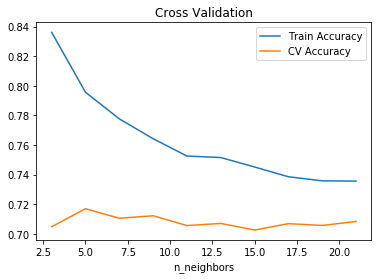

In [137]:
#To avoid overfitting, we used hyper parameter tuning along with 3 fold cross validations
model = KNeighborsClassifier()
k = [3,5,7,9,11,13,15,17,19,21]
k_vals = {'n_neighbors' : k}
best_params = tuning(model, k_vals, 'n_neighbors', x_train, y_train, k)

In [142]:
best_k = best_params['n_neighbors']
knn_clf = KNeighborsClassifier(n_neighbors=best_k).fit(x_train, y_train)
y_pred_knn = knn_clf.predict(x_test)
y_pred_proba_knn = knn_clf.predict_proba(x_test)

In [146]:
y_pred_proba_knn.max(axis=1)

array([0.8, 1. , 0.6, ..., 0.6, 0.6, 0.6])

In [147]:
census_data_df['prediction'] = knn_clf.predict(census_encoded_df)
census_data_df['confidence'] = knn_clf.predict_proba(census_encoded_df).max(axis=1)

In [148]:
th_props = [
  ('font-size', '11px'),
  ('text-align', 'center'),
  ('font-weight', 'bold'),
  ('color', '#6d6d6d'),
  ('background-color', '#f7f7f9')
  ]

# Set CSS properties for td elements in dataframe
td_props = [
  ('font-size', '11px')
  ]
styles = [
  dict(selector="th", props=th_props),
  dict(selector="td", props=td_props)
  ]
cm = sns.light_palette("green", as_cmap=True)

(census_data_df.head(10).style
  .background_gradient(cmap=cm, subset=['income_class','prediction','confidence'])
  .set_caption('KNN Prediction')
  .set_table_styles(styles))

,age,workclass,education_level,education_num_years,marital_status,occupation,relationship,race,sex,avg_hours_per_week_worked,income,income_class,prediction,confidence
0,30,private,some_college,10,separated,sales,unmarried,black,female,16,<=50k,0,0,0.800000
1,34,private,hs_grad,9,never_married,exec_managerial,other_relative,white,male,50,<=50k,0,0,0.800000
2,34,private,hs_grad,9,divorced,machine_op_inspct,unmarried,black,female,40,<=50k,0,0,1.000000
3,30,private,assoc_acdm,12,divorced,sales,not_in_family,white,male,52,<=50k,0,1,0.600000
4,51,self_emp_not_inc,some_college,10,divorced,craft_repair,not_in_family,white,male,8,>50k,1,1,0.600000
5,90,private,hs_grad,9,never_married,other_service,not_in_family,black,male,40,<=50k,0,0,0.800000
6,44,private,masters,14,never_married,prof_specialty,not_in_family,white,female,55,<=50k,0,0,0.800000
7,28,private,hs_grad,9,never_married,exec_managerial,not_in_family,white,female,40,<=50k,0,0,0.800000
8,44,federal_gov,bachelors,13,divorced,exec_managerial,not_in_family,black,female,40,<=50k,0,0,0.800000
9,26,private,9th,5,married_civ_spouse,craft_repair,husband,white,male,20,<=50k,0,0,1.000000


In [93]:
mod_acc = accuracy_score(y_test, y_pred_knn)
mod_f1 = f1_score(y_test, y_pred_knn, average = 'macro')
mod_ll = log_loss(y_test, y_pred_proba_knn)

print('Accuracy of model on testing data is', mod_acc)
print('F1 Score of model on testing data is', mod_f1)
print('Log loss of model on testing data is', mod_ll)

Accuracy of model on testing data is 0.7922222222222223
F1 Score of model on testing data is 0.7116873134994559
Log loss of model on testing data is 1.3393046101551458


-------------------- Confusion matrix --------------------


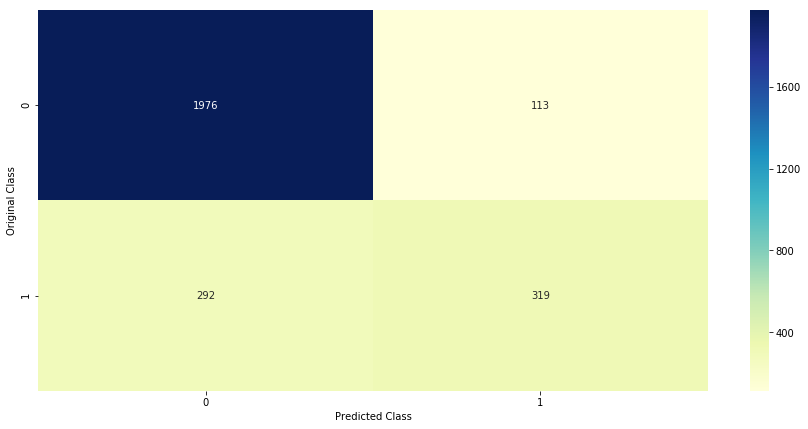

In [109]:
plot_confusion_matrix(y_pred_knn, y_pred)

In [104]:
#Calculating True Positive Rate and False Positive Rate
C = confusion_matrix(y_test, y_pred_knn)
C = C.astype(int)
TN, FP, FN,TP = C[0][0], C[0][1], C[1][0], C[1][1]
KNN_TPR = TP/(TP+FN)
KNN_FPR = FP/(FP+TN)

<h2>Decesion Tree Modelling</h2>

In [107]:
model=DecisionTreeClassifier()
hyperparams = {'criterion':['gini', 'entropy'],'splitter':['best', 'random'],'max_depth':np.linspace(1,120,60,endpoint=True,dtype=int),'min_samples_split':np.linspace(0.1, 1.0, 10, endpoint=True),\
          'min_samples_leaf':np.linspace(0.1, 0.5, 5, endpoint=True)
     }
print("Tuning Hyperparameters...")
best_params = tuning_random(model, hyperparams, 'n_estimators', x_train, y_train, 'params',is_multi=True)
print("Tuning Hyperparameters completed and applying on best model...")
dc_clf = DecisionTreeClassifier(max_depth=best_params['max_depth'],
                        min_samples_split=best_params['min_samples_split'],
                        min_samples_leaf=best_params['min_samples_leaf'],
                        criterion= best_params['criterion'],
                     splitter= best_params['splitter'],random_state=100).fit(x_train, y_train)
y_pred_dt = dc_clf.predict(x_test)
y_pred_proba_dt = dc_clf.predict_proba(x_test)

dt_mod_acc = accuracy_score(y_test, y_pred_dt)
dt_mod_f1 = f1_score(y_test, y_pred_dt, average = 'macro')
dt_mod_ll = log_loss(y_test, y_pred_proba_dt)

print('Accuracy of model on testing data is', dt_mod_acc)
print('F1 Score of model on testing data is', dt_mod_f1)
print('Log loss of model on testing data is', dt_mod_ll)

Tuning Hyperparameters...
Training Completed
Best Parameter is  {'splitter': 'random', 'min_samples_split': 0.2, 'min_samples_leaf': 0.2, 'max_depth': 57, 'criterion': 'gini'}
Best F1 Score is  0.5120216631791815
Tuning Hyperparameters completed and applying on best model...
Accuracy of model on testing data is 0.7644444444444445
F1 Score of model on testing data is 0.6636578947162245
Log loss of model on testing data is 0.42994643770954416


-------------------- Confusion matrix --------------------


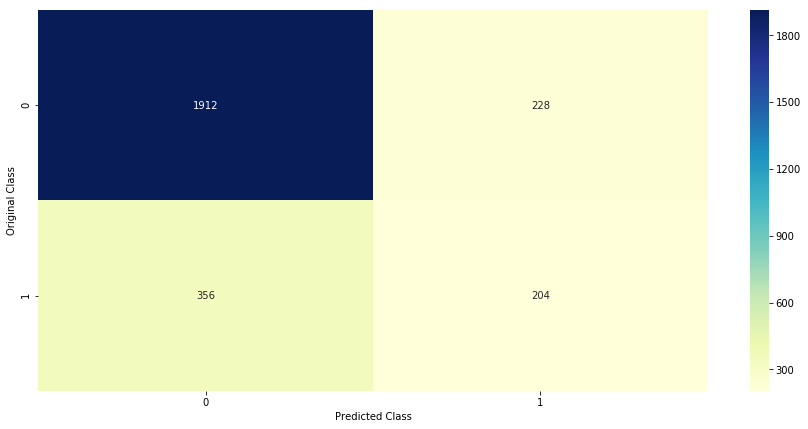

In [108]:
plot_confusion_matrix(y_pred_dt, y_pred)

In [110]:
#Calculating True Positive Rate and False Positive Rate
C = confusion_matrix(y_test, y_pred_dt)
C = C.astype(int)
TN, FP, FN,TP = C[0][0], C[0][1], C[1][0], C[1][1]
DT_TPR = TP/(TP+FN)
DT_FPR = FP/(FP+TN)

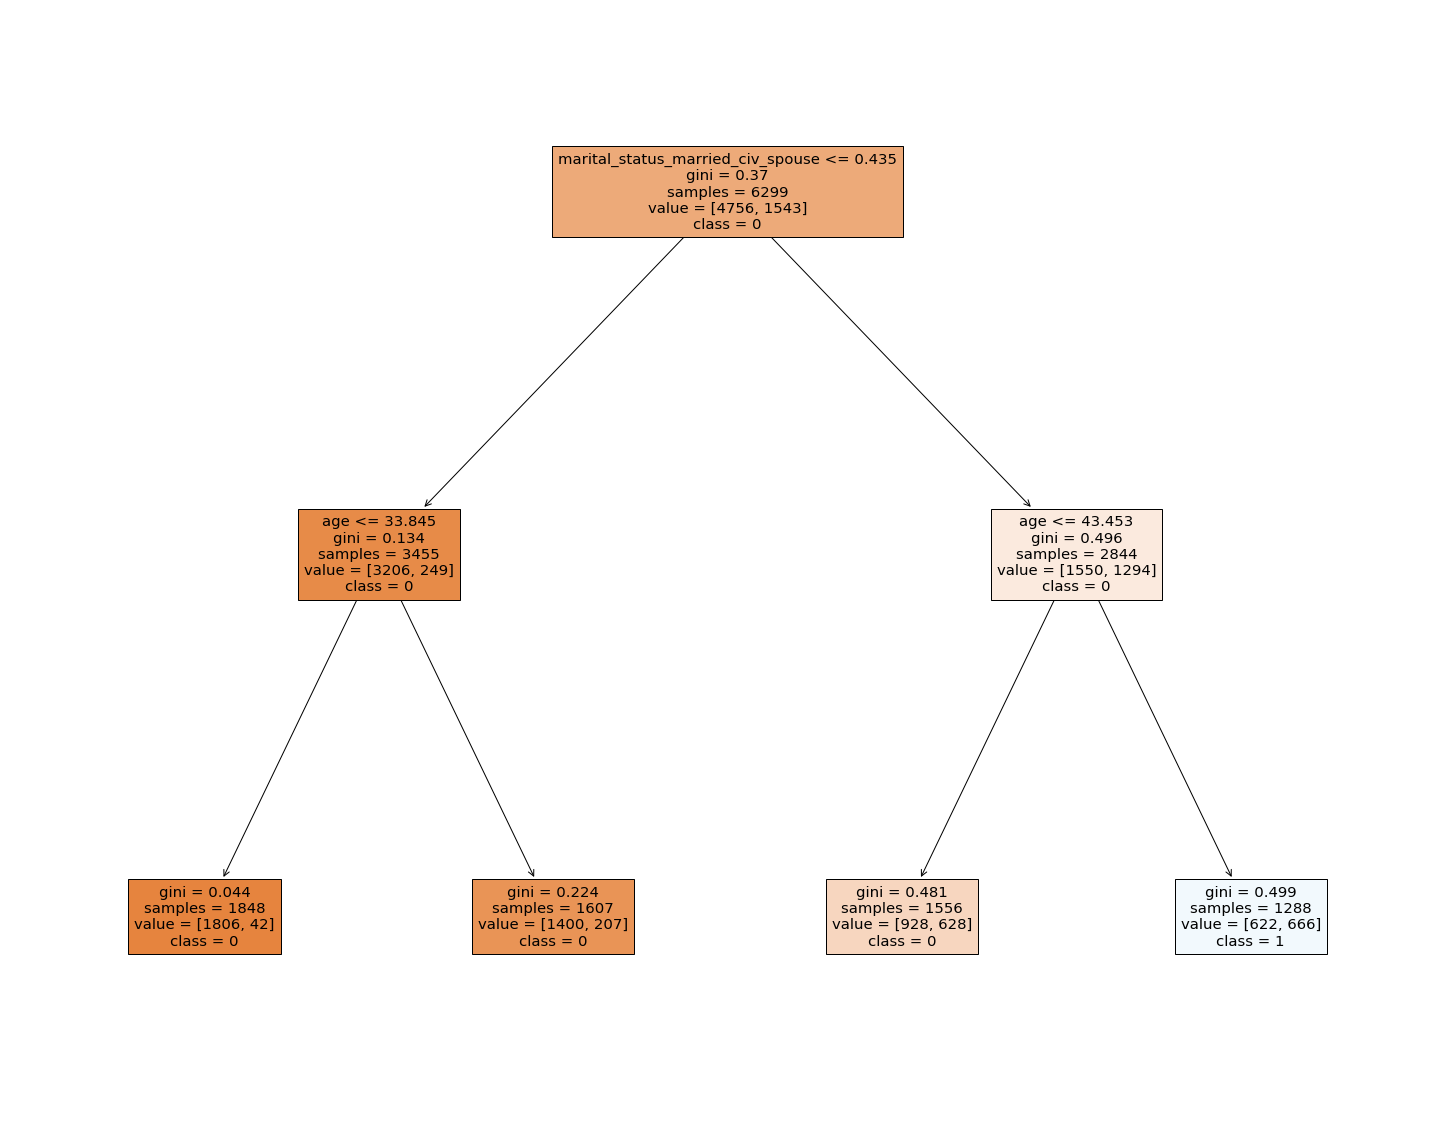

In [121]:
fig = plt.figure(figsize=(25,20))
tree.plot_tree(dc_clf,
               feature_names = x_train.columns, 
               class_names=['0','1'],
               filled = True);

<h2>Results Summary</h2>

In [112]:
Model_Results = pd.DataFrame([['KNN',mod_acc,mod_f1,mod_ll,KNN_TPR,KNN_FPR],['Decesion Tree',dt_mod_acc,dt_mod_f1,dt_mod_ll,DT_TPR,DT_FPR]],columns=['Model','Accuracy','F1_Score','Log_Loss','TPR','FPR'])

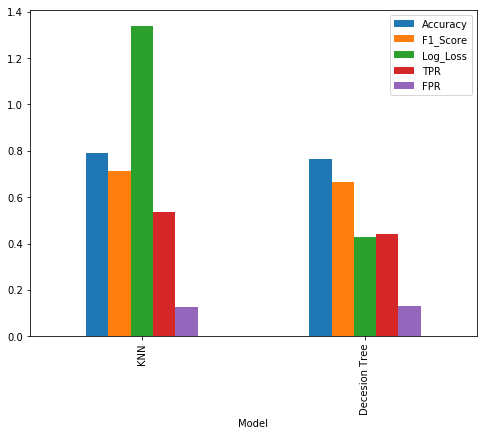

In [114]:
Model_Results.plot(x='Model',y=['Accuracy','F1_Score','Log_Loss','TPR','FPR'], kind='bar',figsize=(8,6))

<h2>Model Summary</h2>

The Accuracy of Knn is higher compared to Decesion Tree

The log loss of DT is good compared to KNN

The TPR and FPR of both the models are comparably equal

The F1 score of the KNN is high compared to Decesion Tree

Overall KNN model is doing good when compared to decesion tree